In [159]:
import numpy as np
import pandas as pd
from keras.models import Model
from keras.layers import Input,Dense,Flatten
from keras.layers import LSTM
from numpy import array

In [160]:
df_train = pd.read_csv('./Train_X.csv',encoding= 'cp950')


In [161]:
data_train = {}
data_test ={}

In [162]:
df_train = df_train.sort_values('日期')
df_test = df_test.sort_values('日期')
stock_list_train = (df_train['股票代號'].unique()).tolist()

for name in stock_list_train:
    data_train[name]=df_train[df_train['股票代號']==name].loc[:,['開盤價', '最高價','最低價','成交量.股.','收盤價']]

In [163]:
columns = data_train['TWA00'].columns

In [164]:
#定義正規化函式
def normalize(train):
    train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train_norm

#定義餵入的feature跟label序列
def train_(df, ref_day, predict_day):
    X_train, Y_train = [], []
    for i in range(df.shape[0]+predict_day-ref_day):
        X_train.append(np.array(df.iloc[i:i+ref_day,0:4]))
        Y_train.append(np.array(df.iloc[i+ref_day : i+ref_day+predict_day,4]))
    return np.array(X_train), np.array(Y_train)

TWA00_train= normalize(data_train['TWA00'])

def denormalize_col0(train,i):
    denorm = train*(np.max(data_train['TWA00'][columns[i]])-np.min(data_train['TWA00'][columns[i]]))+np.mean(data_train['TWA00'][columns[i]])
    return denorm

In [165]:
X_train,Y_train=train_(TWA00_train,5,1)

In [166]:
x_train = np.delete(X_train,232,0)
y_train = np.empty([232,1,1], dtype=float)
for k in range(232):
    y_train[k] = Y_train[k]

y_train = y_train.reshape(232,1)

In [167]:
# define model
import keras
units = 50
inputs1 = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm1=LSTM(units, activation='relu', recurrent_activation='hard_sigmoid',return_sequences=True,dropout=0.3)(inputs1)
lstm2=LSTM(units, activation='relu', recurrent_activation='hard_sigmoid',return_sequences=True,dropout=0.3)(lstm1)
lstm3=LSTM(units, activation='relu', recurrent_activation='hard_sigmoid',return_sequences=True,dropout=0.3)(lstm2)
final=LSTM(1, activation='tanh', recurrent_activation='hard_sigmoid',return_sequences = False)(lstm3)
adam = keras.optimizers.Adam(lr=0.001, beta_1=0.99, beta_2=0.999, amsgrad=False)

model = Model(inputs=inputs1, outputs=final)
model.compile(optimizer=adam, loss='mean_squared_error')
model.fit(x_train,y_train,epochs = 100, batch_size = 20)

In [171]:
df_test = pd.read_csv('./Test_X.csv',encoding= 'cp950')

for name in stock_list_train:
    data_test[name]=df_test[df_test['股票代號']==name].loc[:,['開盤價', '最高價','最低價','成交量.股.','收盤價']]
TWA00_test= normalize(data_test['TWA00'])


def denormalize(train):
    denorm = train*(np.max(data_train['TWA00']['收盤價'])-np.min(data_train['TWA00']['收盤價']))+np.mean(data_train['TWA00']['收盤價'])
    return denorm

In [172]:
X_test,Y_test=train_(TWA00_test,5,1)
#test_y = pd.DataFrame(TWA00_test)
a = denormalize(TWA00_test)
#z = denormalize(predict_y)

In [179]:
matrix = np.zeros((1,5,4))
trans = x_train[-1].reshape(1,5,4)
result= []
for i in range(10):
    if i<=4 :
        result.append(denormalize(model.predict(trans)))
        #print('i = ',i ,"\n",trans)
        matrix[0][0:4] = trans[0][1:5]
        matrix[0][4] = X_test[0][i]
        trans = matrix
    else:
        #print('i = ',i ,"\n",X_test[i-5])
        result.append(denormalize(model.predict(X_test[i-5].reshape(1,5,4))))

In [174]:
re= []
for i in range(10):
    re.append(result[i][0][0])

In [175]:
#c = denormalize(model.predict(X_test))
#b= denormalize(Y_test)

In [176]:
a = denormalize(TWA00_test['收盤價']).tolist()

In [177]:
a

[9394.496448738962,
 9451.625644127163,
 9234.694727409389,
 9220.516445304642,
 9043.30392157105,
 9131.254077832547,
 8848.104502706825,
 8839.431106656293,
 8533.845920344509,
 8146.935644127163]

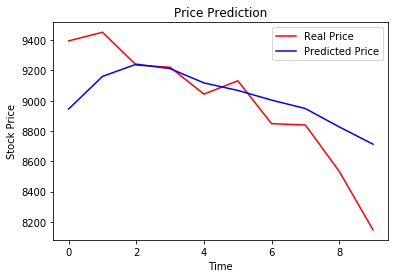

In [178]:
import matplotlib.pyplot as plt 
plt.plot(range(10),a, color = 'red', label = 'Real Price')  # 紅線表示真實股價
plt.plot(range(10),re, color = 'blue', label = 'Predicted Price')  # 藍線表示預測股價
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()